<>:149: SyntaxWarning: invalid escape sequence '\g'
<>:149: SyntaxWarning: invalid escape sequence '\g'
C:\Users\guoka\AppData\Local\Temp\ipykernel_47640\2058002979.py:149: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f'Differential Transmission (g={g_eff/kappa}, $\gamma_\phi$={gamma_phi/kappa})')


初始化模拟: dt = 0.0122, pulse_width = 0.0500
如果 dt > pulse_width，模拟将失败。当前状态: 安全
开始扫描 21 个延迟点...


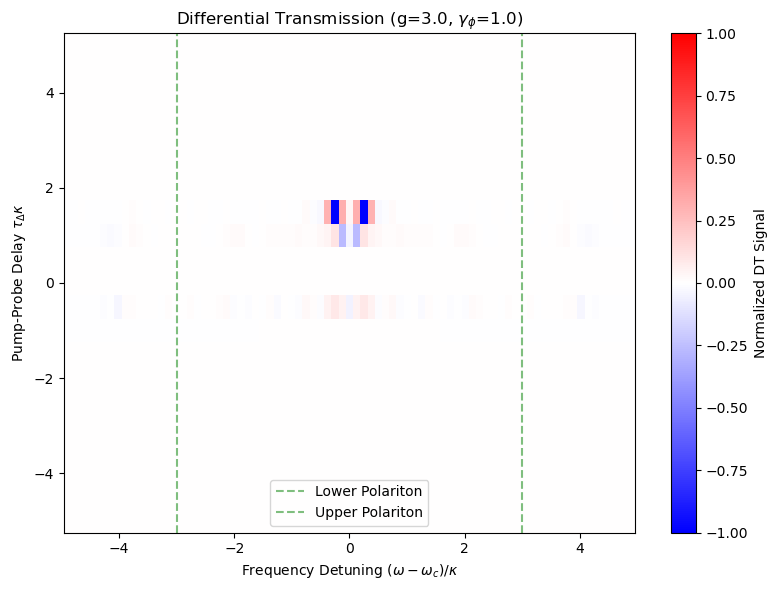

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftshift, fftfreq
from scipy.interpolate import interp1d  # 引入插值函数

# ==========================================
# 1. 物理参数设置 (严格对应论文 Fig. 3b)
# ==========================================
kappa = 1.0                 # 单位归一化
gamma_phi = 1.0 * kappa     # 强退相干
gamma_pop = 0.01 * kappa    # 布居数弛豫
g_eff = 3.0 * kappa         # 耦合强度 g*sqrt(N)
omega_c = 0.0               
omega_0 = 0.0               

# 关键：脉冲宽度很窄，需要足够的网格密度
sigma_t = 0.05 / kappa      
eta_pump = 0.5              # 稍微增大泵浦强度以确保非线性效应明显
eta_probe = 0.01            

# 时间网格 (加密网格以捕捉窄脉冲)
t_min = -10.0 / kappa       # 缩短窗口，集中在脉冲附近
t_max = 40.0 / kappa
num_points = 4096           # 【关键修改】提高分辨率，避免漏掉脉冲
t_eval = np.linspace(t_min, t_max, num_points)
dt = t_eval[1] - t_eval[0]

# ==========================================
# 2. 定义函数
# ==========================================

def gaussian_pulse(t, t0, width, amplitude):
    # 避免除零或极小数值问题
    return amplitude * np.exp(-((t - t0)**2) / (2 * width**2))

# ==========================================
# 3. 分步模拟计算
# ==========================================
print(f"初始化模拟: dt = {dt:.4f}, pulse_width = {sigma_t:.4f}")
print("如果 dt > pulse_width，模拟将失败。当前状态: " + ("安全" if dt < sigma_t else "危险！网格太粗"))

# --- Step 1: 泵浦光一阶线性响应 (Pump Linear) ---
def pump_linear_ode(t, y):
    alpha, v = y[0], y[1]
    drive = gaussian_pulse(t, 0.0, sigma_t, eta_pump)
    d_alpha = -(0.5 * kappa + 1j * omega_c) * alpha - 1j * g_eff * v - drive
    d_v = -(0.5*kappa + gamma_phi + 1j*omega_0) * v - 1j * g_eff * alpha 
    return [d_alpha, d_v]

sol_pump = solve_ivp(pump_linear_ode, [t_min, t_max], [0j, 0j], t_eval=t_eval)
alpha_p1 = sol_pump.y[0]
v_p1 = sol_pump.y[1]

# --- Step 2: 泵浦光制造的布居数 (Pump Induced Population) ---
# 计算驱动源： 2 * g * Im(alpha * v*)
# 这是一个实数数组，不需要解微分方程，直接积分即可
pop_drive_source = 2 * g_eff * np.imag(np.conj(alpha_p1) * v_p1)
w_p2 = np.zeros_like(t_eval, dtype=float)

# 使用简单的欧拉积分计算累积布居数
current_pop = 0.0
for i in range(1, len(t_eval)):
    # d(rho)/dt = -gamma * rho + source
    current_pop += (-gamma_pop * current_pop + pop_drive_source[i]) * dt
    w_p2[i] = current_pop

# 【关键修改】创建插值函数，以便在下一步ODE中精确调用
f_w_p2 = interp1d(t_eval, w_p2, kind='linear', fill_value=0.0, bounds_error=False)

# --- Step 3: 扫描延迟，计算探测光非线性信号 ---
tau_delays = np.linspace(-5, 5, 21)
dt_spectra_map = []

print(f"开始扫描 {len(tau_delays)} 个延迟点...")

for i_tau, tau in enumerate(tau_delays):
    t_probe_center = tau # 泵浦在0，探测在tau
    
    # a. 探测光线性响应 (Probe Linear) - 用于干涉参考
    # 这里为了快，可以直接用解析解或平移Pump结果，但重算一遍最稳妥
    def probe_linear_ode(t, y):
        alpha, v = y[0], y[1]
        drive = gaussian_pulse(t, t_probe_center, sigma_t, eta_probe)
        d_alpha = -(0.5 * kappa + 1j * omega_c) * alpha - 1j * g_eff * v - drive
        d_v = -(0.5*kappa + gamma_phi + 1j*omega_0) * v - 1j * g_eff * alpha
        return [d_alpha, d_v]
        
    sol_probe = solve_ivp(probe_linear_ode, [t_min, t_max], [0j, 0j], t_eval=t_eval)
    alpha_pr1 = sol_probe.y[0]
    
    # 【关键修改】探测光场的插值函数
    f_alpha_pr1 = interp1d(t_eval, alpha_pr1, kind='cubic', fill_value=0.0, bounds_error=False)

    # b. 非线性信号 (Signal Generation)
    def signal_ode(t, y):
        a_sig, v_sig = y[0], y[1]
        
        # 【关键修改】使用插值获取当前时刻的值，而不是用 int(idx)
        val_alpha_pr1 = f_alpha_pr1(t)
        val_w_p2 = f_w_p2(t)
        
        # 信号场的动力学
        d_a = -(0.5*kappa + 1j*omega_c)*a_sig - 1j*g_eff*v_sig
        
        # 极化非线性驱动项: i * g * E_probe * (2 * rho_excited)
        # 物理意义：探测光感受到了泵浦光制造的“空穴”（Rabi分裂收缩的来源）
        nonlinear_drive = 1j * g_eff * val_alpha_pr1 * (2 * val_w_p2)
        
        d_v = -(0.5*kappa + gamma_phi + 1j*omega_0)*v_sig - 1j*g_eff * a_sig + nonlinear_drive
        return [d_a, d_v]

    sol_sig = solve_ivp(signal_ode, [t_min, t_max], [0j, 0j], t_eval=t_eval)
    alpha_sig = sol_sig.y[0]
    
    # c. 计算 DT 谱 (Heterodyne Detection)
    # FFT
    freqs = fftshift(fftfreq(num_points, dt)) * 2 * np.pi
    spec_pr1 = fftshift(fft(alpha_pr1))
    spec_sig = fftshift(fft(alpha_sig))
    
    # DT ~ Re[ E_probe* . E_signal ]
    dt_signal = np.real(np.conj(spec_pr1) * spec_sig)
    dt_spectra_map.append(dt_signal)

# ==========================================
# 4. 绘图
# ==========================================
dt_spectra_map = np.array(dt_spectra_map)

# 归一化数据，防止信号太弱看不见
max_val = np.max(np.abs(dt_spectra_map))
if max_val > 0:
    dt_spectra_map /= max_val

plt.figure(figsize=(8, 6))

# 限制频率显示范围 (-5 到 5)
freq_mask = (freqs > -5*kappa) & (freqs < 5*kappa)
X, Y = np.meshgrid(freqs[freq_mask], tau_delays)
Z = dt_spectra_map[:, freq_mask]

# 使用 raw string (r'...') 解决 SyntaxWarning
plt.pcolormesh(X, Y, Z, shading='auto', cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(label='Normalized DT Signal')

plt.xlabel(r'Frequency Detuning $(\omega - \omega_c) / \kappa$')
plt.ylabel(r'Pump-Probe Delay $\tau_{\Delta} \kappa$')
plt.title(f'Differential Transmission (g={g_eff/kappa}, $\gamma_\phi$={gamma_phi/kappa})')

# 标出线性 Rabi 分裂位置
plt.axvline(x=-g_eff, color='g', linestyle='--', alpha=0.5, label='Lower Polariton')
plt.axvline(x=g_eff, color='g', linestyle='--', alpha=0.5, label='Upper Polariton')
plt.legend()

plt.tight_layout()
plt.show()